In [1]:
import numpy as np
import pandas as pd
import io
import random
import itertools
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
## Read weights and costs 

data_name = 'RGP100'
weights = pd.read_excel('/content/drive/My Drive/sc1-data/' + data_name + '_flow.xlsx', header=None)
costs = pd.read_excel('/content/drive/My Drive/sc1-data/' + data_name + '_cost.xlsx', header=None)

weights.index = range(1, len(weights.index)+1)
weights.columns = range(1, len(weights.columns)+1)
costs.index = range(1, len(costs.index)+1)
costs.columns = range(1, len(costs.columns)+1)

#CAB25:  n = 25,  p = 3,5
#TR55:   n = 55,  p = 3,5
#TR81:   n = 81,  p = 5,7
#RGP100: n = 100, p = 7,10

n = 100
p = 7

In [3]:
## Generate random candidate solution

def generate_candidate(n,p):

  hubs = random.sample(range(1, n+1), p) 
  solution = [ni if ni in hubs else random.choice(hubs) for ni in range(1,n+1)]

  return solution

In [4]:
## Generate discrete population of candidate solutions

def generate_population(n,p,size):
  
  pop = []

  for i in range(size):
    pop.append(generate_candidate(n,p))

  return pop


In [5]:
## Calculate net cost for flow between hubs

def total_flow_cost(flow_sum):

  slope = 0
  intercept = 0
  check = flow_sum/1000

  if   0<=check<50:     slope = 1.0; intercept = 0
  elif 50<=check<100:   slope = 0.8; intercept = 10000
  elif 100<=check<200:  slope = 0.6; intercept = 30000
  elif 200<=check:      slope = 0.4; intercept = 70000

  return slope*flow_sum + intercept

In [6]:
## Model the hubs-and-nodes network as a dictionary

def network(candidate):

  hubs = set(candidate)
  candidate = np.array(candidate)
  network = {h:list(np.where(candidate == h)[0]+1) for h in hubs}

  return network

In [8]:
## Calculate total cost (fitness) of a candidate

def total_cost(candidate):

  total_cost = 0

  #collection and distribution costs
  for i in range(len(candidate)):
    for j in range(len(candidate)):
      node_i = i+1
      node_j = j+1
      hub_k = candidate[i]
      hub_m = candidate[j]

      total_cost += weights[node_i][node_j]*(costs[node_i][hub_k] + costs[hub_m][node_j])

  #transfer costs
  hub_network = network(candidate)
  for k in hub_network:
    for m in hub_network:

      if(k!=m): 
        nodes_at_k = hub_network[k]
        nodes_at_m = hub_network[m]
        nodes_pairs = list(itertools.product(nodes_at_k, nodes_at_m))
        
        flow_sum = sum([weights[kk][mm] for (kk,mm) in nodes_pairs])
        flow_cost = total_flow_cost(flow_sum)

        total_cost += flow_cost*costs[k][m]

  return total_cost

In [9]:
## Tournament selection

def selection(population, fitnesses, T_size):

  tournament = random.sample(range(len(population)), T_size)

  winner_ind = tournament[0]
  for t_ind in tournament[1:]:
    if fitnesses[t_ind] > fitnesses[winner_ind]:
      winner = t_ind

  #return the winning candidate
  return population[winner_ind]

In [10]:
## Crossover 1

def crossover1(parent1, parent2):

  parents = [parent1,parent2]
  child1 = []
  child2 = []

  for i in range(len(parents[0])):
    ind = random.randint(0, 1)
    child1.append(parents[ind][i])
    child2.append(parents[ind^1][i])

  return child1,child2

In [12]:
## Crossover 3

def crossover3(parent1, parent2, p):

  n = len(parent1)
  parents = [parent1,parent2]
  sets = set(parent1).union(set(parent2))
  children = [[None]*n,[None]*n]

  for child in children:

    #allocating hubs
    hubs = random.sample(sets, p)
    for h in hubs:
      child[h-1] = h
    
    #allocating nodes to hubs
    for i in range(n):
      if (child[i]==None):

        ind = random.randint(0, 1)
        node1 = parents[ind][i]
        node2 = parents[ind^1][i]

        if (node1 in set(child)):
          child[i] = node1
        elif (node2 in set(child)):
          child[i] = node2

    #repairing unallocated nodes
    for i in range(n):
      if (child[i]==None):
        hubs = set(child)
        hubs.remove(None)
        child[i] = random.choice(tuple(hubs))
      

  return children[0], children[1]

In [14]:
## Mutation

def mutation(candidate, mr):

  hubs = set(candidate)

  for i in range(len(candidate)):
    hub_i = candidate[i]
    node_i = i+1

    if node_i != hub_i:
      if random.random() < mr:
        hubs.remove(hub_i)
        candidate[i] = random.choice(tuple(hubs))
        hubs.add(hub_i)

  return candidate

In [15]:
## PROGRAM RUN

def model_1(n,p,time_steps,pop_size,mr):

  #generate initial population
  population = generate_population(n,p,pop_size)
  fitnesses = []

  best_fs = []
  best_cs = []

  for t in range(time_steps):

    #fitness evaluation
    fitnesses = [total_cost(candidate) for candidate in population]
    best_fitness = min(fitnesses)
    best_candidate = population[np.argmin(fitnesses)]
    best_fs.append(best_fitness)
    best_cs.append(best_candidate)

    #selection
    selected = [selection(population, fitnesses, T_size=10) for _ in range(pop_size)]

    new_population = []

    #crossover and mutation
    for i in range(0, pop_size, 2):

      randoms = random.sample(selected, 2)
      selected.remove(randoms[0])
      selected.remove(randoms[1])
      child1, child2 = crossover3(randoms[0],randoms[1],p)
      child1 = mutation(child1,mr)
      child2 = mutation(child2,mr)

      new_population.append(child1)
      new_population.append(child2)

    #update population
    population = new_population

    #print("Iteration {}: Best Fitness = {}, Best Individual = {}".format(t, best_fitness, best_candidate))

  return best_fs, best_cs

In [ ]:
best_fs, best_cs = model_1(n=10,p=3,time_steps=50,pop_size=100,mr=0.4)
print(best_fs)
print(best_cs)

Iteration 0: Best Fitness = 849592073.2330399, Best Individual = [4, 9, 3, 4, 4, 9, 4, 4, 9, 4]
Iteration 1: Best Fitness = 932992793.9081203, Best Individual = [5, 6, 6, 4, 5, 6, 5, 5, 5, 6]
Iteration 2: Best Fitness = 879204578.3164003, Best Individual = [9, 5, 9, 9, 5, 9, 10, 10, 9, 10]
Iteration 3: Best Fitness = 893713618.9126003, Best Individual = [6, 9, 9, 9, 6, 6, 10, 6, 9, 10]
Iteration 4: Best Fitness = 831705540.7622404, Best Individual = [1, 9, 9, 4, 9, 9, 4, 4, 9, 4]
Iteration 5: Best Fitness = 822895549.5699201, Best Individual = [9, 2, 9, 9, 9, 9, 7, 9, 9, 7]
Iteration 6: Best Fitness = 804849062.3242396, Best Individual = [4, 4, 4, 4, 5, 4, 7, 7, 4, 7]
Iteration 7: Best Fitness = 889517067.5537201, Best Individual = [6, 9, 9, 6, 6, 6, 7, 6, 9, 7]
Iteration 8: Best Fitness = 913851077.8401599, Best Individual = [5, 5, 5, 4, 5, 4, 7, 5, 5, 5]
Iteration 9: Best Fitness = 925366844.7905197, Best Individual = [5, 9, 4, 4, 5, 9, 4, 9, 9, 5]
Iteration 10: Best Fitness = 785196

In [ ]:
## Experiment with Mutation Rates

best_fitnesses_mrs = []
best_candidates_mrs = []
mrs = np.arange(0.1,1,0.1)

for mr in mrs:

  best_fs, best_cs = model_1(n=10,p=3,time_steps=50,pop_size=100,mr=mr)
  best_fitnesses_mrs.append(min(best_fs))
  best_candidates_mrs.append(best_cs[np.argmin(best_fs)])

  print("Mutation Rate {}: Best Fitness = {}, Best Individual = {}".format(mr, best_fitnesses_mrs[-1], best_candidates_mrs[-1]))


Mutation Rate 0.1: Best Fitness = 811515219.33444, Best Individual = [5, 2, 5, 5, 5, 5, 7, 7, 5, 7]
Mutation Rate 0.2: Best Fitness = 794343990.8103199, Best Individual = [9, 9, 9, 4, 9, 4, 7, 7, 9, 7]
Mutation Rate 0.30000000000000004: Best Fitness = 795408594.3057201, Best Individual = [9, 2, 9, 9, 9, 9, 7, 7, 9, 7]
Mutation Rate 0.4: Best Fitness = 823532721.3383602, Best Individual = [5, 9, 9, 4, 5, 9, 4, 4, 9, 4]
Mutation Rate 0.5: Best Fitness = 746458661.9294802, Best Individual = [4, 6, 6, 4, 6, 6, 7, 4, 6, 7]
Mutation Rate 0.6: Best Fitness = 782944749.53096, Best Individual = [6, 6, 6, 4, 6, 6, 10, 4, 6, 10]
Mutation Rate 0.7000000000000001: Best Fitness = 769427677.5677601, Best Individual = [1, 9, 9, 9, 9, 9, 7, 7, 9, 7]
Mutation Rate 0.8: Best Fitness = 826884782.11516, Best Individual = [9, 9, 6, 9, 9, 6, 7, 9, 9, 7]
Mutation Rate 0.9: Best Fitness = 745421728.6328803, Best Individual = [4, 6, 6, 4, 4, 6, 7, 4, 6, 7]


Text(0.5, 1.0, 'Mutation Rates vs Best Fitness')

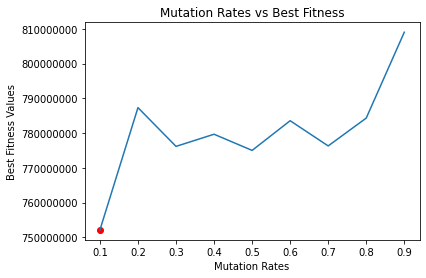

In [ ]:
min_fs = min(best_fitnesses_mrs)
min_fs_mr = mrs[np.argmin(best_fitnesses_mrs)]

plt.plot(mrs, best_fitnesses_mrs)
plt.scatter(min_fs_mr, min_fs, color = 'r')
plt.ticklabel_format(style='plain')
plt.xlabel('Mutation Rates')
plt.ylabel('Best Fitness Values')
plt.title('Mutation Rates vs Best Fitness')

In [ ]:
## Experiment with Time Steps

best_fitnesses_ts = []
best_candidates_ts = []
ts = np.arange(50,350,50)

for t in ts:

  best_fs, best_cs = model_1(n=10,p=3,time_steps=t,pop_size=100,mr=0.4)
  best_fitnesses_ts.append(min(best_fs))
  best_candidates_ts.append(best_cs[np.argmin(best_fs)])

  print("Time Steps {}: Best Fitness = {}, Best Individual = {}".format(t, best_fitnesses_ts[-1], best_candidates_ts[-1]))


Time Steps 50: Best Fitness = 752124310.7995203, Best Individual = [6, 6, 6, 4, 6, 6, 7, 7, 6, 7]
Time Steps 100: Best Fitness = 740999438.9360801, Best Individual = [4, 9, 9, 4, 4, 9, 7, 4, 9, 7]
Time Steps 150: Best Fitness = 745421728.6328803, Best Individual = [4, 6, 6, 4, 4, 6, 7, 4, 6, 7]
Time Steps 200: Best Fitness = 752140732.5358402, Best Individual = [9, 9, 9, 4, 4, 9, 7, 4, 9, 7]
Time Steps 250: Best Fitness = 787108408.1376, Best Individual = [6, 6, 6, 4, 4, 6, 10, 4, 6, 10]
Time Steps 300: Best Fitness = 781833801.0026001, Best Individual = [5, 9, 9, 9, 5, 9, 7, 7, 9, 7]


Text(0.5, 1.0, 'Time Steps vs Best Fitness')

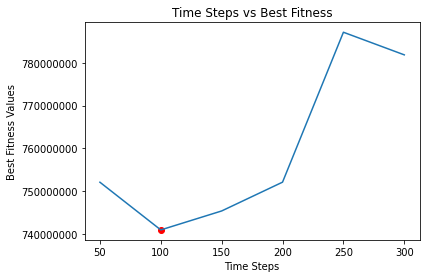

In [ ]:
min_fs = min(best_fitnesses_ts)
min_fs_ts = ts[np.argmin(best_fitnesses_ts)]

plt.plot(ts, best_fitnesses_ts)
plt.scatter(min_fs_ts, min_fs, color = 'r')
plt.ticklabel_format(style='plain')
plt.xlabel('Time Steps')
plt.ylabel('Best Fitness Values')
plt.title('Time Steps vs Best Fitness')

In [ ]:
## Experiment with Population Size

best_fitnesses_pop = []
best_candidates_pop = []
pops = np.arange(50,350,50)

for pop in pops:

  best_fs, best_cs = model_1(n=10,p=3,time_steps=100,pop_size=pop,mr=0.4)
  best_fitnesses_pop.append(min(best_fs))
  best_candidates_pop.append(best_cs[np.argmin(best_fs)])

  print("Population Size {}: Best Fitness = {}, Best Individual = {}".format(pop, best_fitnesses_pop[-1], best_candidates_pop[-1]))

Population Size 50: Best Fitness = 810984105.25348, Best Individual = [5, 5, 9, 5, 5, 9, 7, 7, 9, 7]
Population Size 100: Best Fitness = 752734626.1894001, Best Individual = [4, 9, 9, 4, 9, 9, 7, 7, 9, 7]
Population Size 150: Best Fitness = 740999438.9360801, Best Individual = [4, 9, 9, 4, 4, 9, 7, 4, 9, 7]
Population Size 200: Best Fitness = 759939716.3029205, Best Individual = [4, 4, 9, 4, 4, 9, 7, 4, 9, 7]
Population Size 250: Best Fitness = 756453537.6539602, Best Individual = [6, 6, 6, 4, 4, 6, 7, 7, 6, 7]
Population Size 300: Best Fitness = 755518888.8010001, Best Individual = [4, 6, 6, 4, 6, 6, 7, 7, 6, 7]


Text(0.5, 1.0, 'Population Size vs Best Fitness')

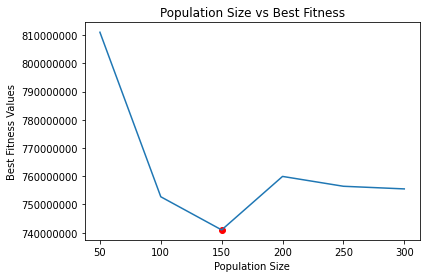

In [ ]:
min_fs = min(best_fitnesses_pop)
min_fs_pop = ts[np.argmin(best_fitnesses_pop)]

plt.plot(pops, best_fitnesses_pop)
plt.scatter(min_fs_pop, min_fs, color = 'r')
plt.ticklabel_format(style='plain')
plt.xlabel('Population Size')
plt.ylabel('Best Fitness Values')
plt.title('Population Size vs Best Fitness')

In [ ]:
## Model 1 FINAL RUN
## change problem dataset

best_fitnesses_m1 = []
best_candidates_m1 = []
time_m1 = []

for i in range(10):

  start = time.time()
  best_fs, best_cs = model_1(n=100,p=10,time_steps=50,pop_size=150,mr=0.4)
  end = time.time()


  best_fitnesses_m1.append(min(best_fs))
  best_candidates_m1.append(best_cs[np.argmin(best_fs)])
  time_m1.append(end-start)

  print("Iteration {}: Best Fitness = {}, Best Individual = {}, Time = {}".format(i+1, best_fitnesses_m1[-1], best_candidates_m1[-1], time_m1[-1]))

In [32]:
min_fs = min(best_fitnesses_m1)
runs = np.arange(1,11)
min_run = runs[np.argmin(best_fitnesses_m1)]
avg_fs = np.mean(best_fitnesses_m1)
best_cs = best_candidates_m1[np.argmin(best_fitnesses_m1)]
avg_time = np.mean(time_m1)

print('Best Solution: {}'.format(str(best_cs)))
print('Best NC: {}'.format(min_fs))
print('Avg NC: {}'.format(avg_fs))
print('Avg Time: {}'.format(avg_time))

plt.plot(runs, best_fitnesses_m1)
plt.scatter(min_run, min_fs, color = 'r', label = 'Best Fitness')
plt.axhline(y=avg_fs, color='y', linestyle='--', label = 'Avg Fitness')
plt.ticklabel_format(style='plain')
plt.xticks(runs)
plt.legend()
plt.xlabel('Runs')
plt.ylabel('Best Fitness Values')
plt.title('Best Fitness in Each Run')

Best Solution: [71, 42, 3, 60, 71, 60, 3, 3, 3, 64, 19, 3, 60, 41, 3, 19, 41, 41, 19, 3, 41, 71, 71, 42, 64, 41, 41, 64, 64, 3, 42, 64, 42, 41, 3, 60, 71, 41, 41, 71, 41, 42, 60, 71, 64, 41, 3, 3, 42, 60, 41, 60, 64, 64, 42, 60, 3, 60, 42, 60, 3, 64, 3, 64, 71, 71, 3, 71, 19, 71, 71, 60, 3, 3, 64, 64, 64, 3, 41, 64, 64]
Best NC: 74259014548.93364
Avg NC: 75587104933.5132
Avg Time: 2169.327643712362


"plt.plot(runs, best_fitnesses_m1)\nplt.scatter(min_run, min_fs, color = 'r', label = 'Best Fitness')\nplt.axhline(y=avg_fs, color='y', linestyle='--', label = 'Avg Fitness')\nplt.ticklabel_format(style='plain')\nplt.xticks(runs)\nplt.legend()\nplt.xlabel('Runs')\nplt.ylabel('Best Fitness Values')\nplt.title('Best Fitness in Each Run')"